# Import Library

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
from torch.autograd import Variable

from src.net import vgg16, vgg16_bn
from src.resnet_yolo import resnet50, resnet18
from src.plot import plot
from src.yoloLoss import yoloLoss
from src.dataset import yoloDataset

import numpy as np
import src.nntools as nt
from matplotlib import pyplot as plt

# VGG16_BN pretrained model

### Initialize Parameters

In [2]:
use_gpu = torch.cuda.is_available()

file_root = '~/YOLO/assets/VOCTrainVal/VOC20072012/JPEGImages/'
learning_rate = 0.00001
num_epochs = 50
batch_size = 8
use_resnet = False
criterion = yoloLoss(7,2,5,0.5)

if use_resnet:
    net = resnet50()
else:
    net = vgg16_bn()

In [3]:
if use_resnet:
    resnet = models.resnet50(pretrained=True)
    new_state_dict = resnet.state_dict()
    dd = net.state_dict()
    for k in new_state_dict.keys():
        if k in dd.keys() and not k.startswith('fc'):
            dd[k] = new_state_dict[k]
    net.load_state_dict(dd)
else:
    vgg = models.vgg16_bn(pretrained=True)
    new_state_dict = vgg.state_dict()
    dd = net.state_dict()
    for k in new_state_dict.keys():
        if k in dd.keys() and k.startswith('features'):
            dd[k] = new_state_dict[k]
    net.load_state_dict(dd)

In [4]:
if use_gpu:
    net.cuda()
net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [5]:
params=[]
params_dict = dict(net.named_parameters())
for key,value in params_dict.items():
    if key.startswith('features'):
        params += [{'params':[value],'lr':learning_rate*1}]
    else:
        params += [{'params':[value],'lr':learning_rate}]

In [6]:
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Load Dataset

### Training dataset

In [7]:
train_dataset = yoloDataset(root=file_root,list_file='assets/train.txt',train=True,transform = [transforms.ToTensor()])

data init


### Validation dataset

In [8]:
test_dataset = yoloDataset(root=file_root,list_file='assets/val.txt',train=False,transform = [transforms.ToTensor()])

data init


In [9]:
print('the training dataset has {length} images'.format(length=len(train_dataset)))
print('the validation dataset has {length} images'.format(length=len(test_dataset)))
print('the batch size is %d' % (batch_size))

the training dataset has 14896 images
the validation dataset has 1655 images
the batch size is 8


# Stats Manager

In [10]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
        
    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((y == d).float())
        
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = 100*self.running_accuracy / self.number_update
        return {'loss': loss, 'accuracy': accuracy}

In [11]:
stats_manager = ClassificationStatsManager()

# Create Experiment

In [12]:
exp1 = nt.Experiment(net, train_dataset, test_dataset, optimizer, criterion, stats_manager, output_dir="model/vgg16_bn", batch_size=batch_size, perform_validation_during_training=True)

# Training 

Finish training for 50 epochs


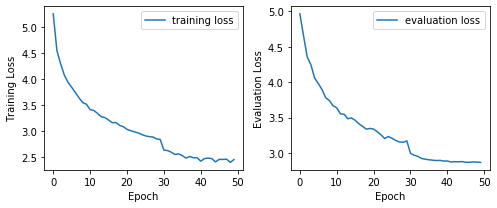

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=num_epochs, use_gpu = True, plot=lambda exp: plot(exp1, fig=fig, axes=axes))

# Resnet50 pretrained model

### Initialize parameters

In [14]:
use_resnet = True

if use_resnet:
    net = resnet50()
else:
    net = vgg16_bn()
    
if use_resnet:
    resnet = models.resnet50(pretrained=True)
    new_state_dict = resnet.state_dict()
    dd = net.state_dict()
    for k in new_state_dict.keys():
        if k in dd.keys() and not k.startswith('fc'):
            dd[k] = new_state_dict[k]
    net.load_state_dict(dd)
else:
    vgg = models.vgg16_bn(pretrained=True)
    new_state_dict = vgg.state_dict()
    dd = net.state_dict()
    for k in new_state_dict.keys():
        if k in dd.keys() and k.startswith('features'):
            dd[k] = new_state_dict[k]
    net.load_state_dict(dd)

In [15]:
if use_gpu:
    net.cuda()
net.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
params=[]
params_dict = dict(net.named_parameters())
for key,value in params_dict.items():
    if key.startswith('features'):
        params += [{'params':[value],'lr':learning_rate*1}]
    else:
        params += [{'params':[value],'lr':learning_rate}]

In [17]:
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=5e-4)
stats_manager = ClassificationStatsManager()

# Create Experiment

In [18]:
exp2 = nt.Experiment(net, train_dataset, test_dataset, optimizer, criterion, stats_manager, output_dir="model/resnet50", batch_size=batch_size, perform_validation_during_training=True)

# Training

Finish training for 50 epochs


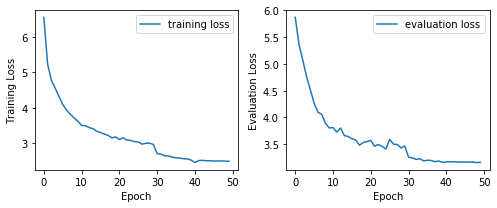

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=num_epochs, use_gpu = True, plot=lambda exp: plot(exp2, fig=fig, axes=axes))